In [50]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [55]:
engine = create_engine("sqlite:///hawaii.sqlite")
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [56]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(engine)

In [60]:
engine.execute('Select * From Station Limit 5').fetchall()
engine.execute('Select * From Measurement Limit 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

('2017-08-23',)
2016-08-23


<IPython.core.display.Javascript object>


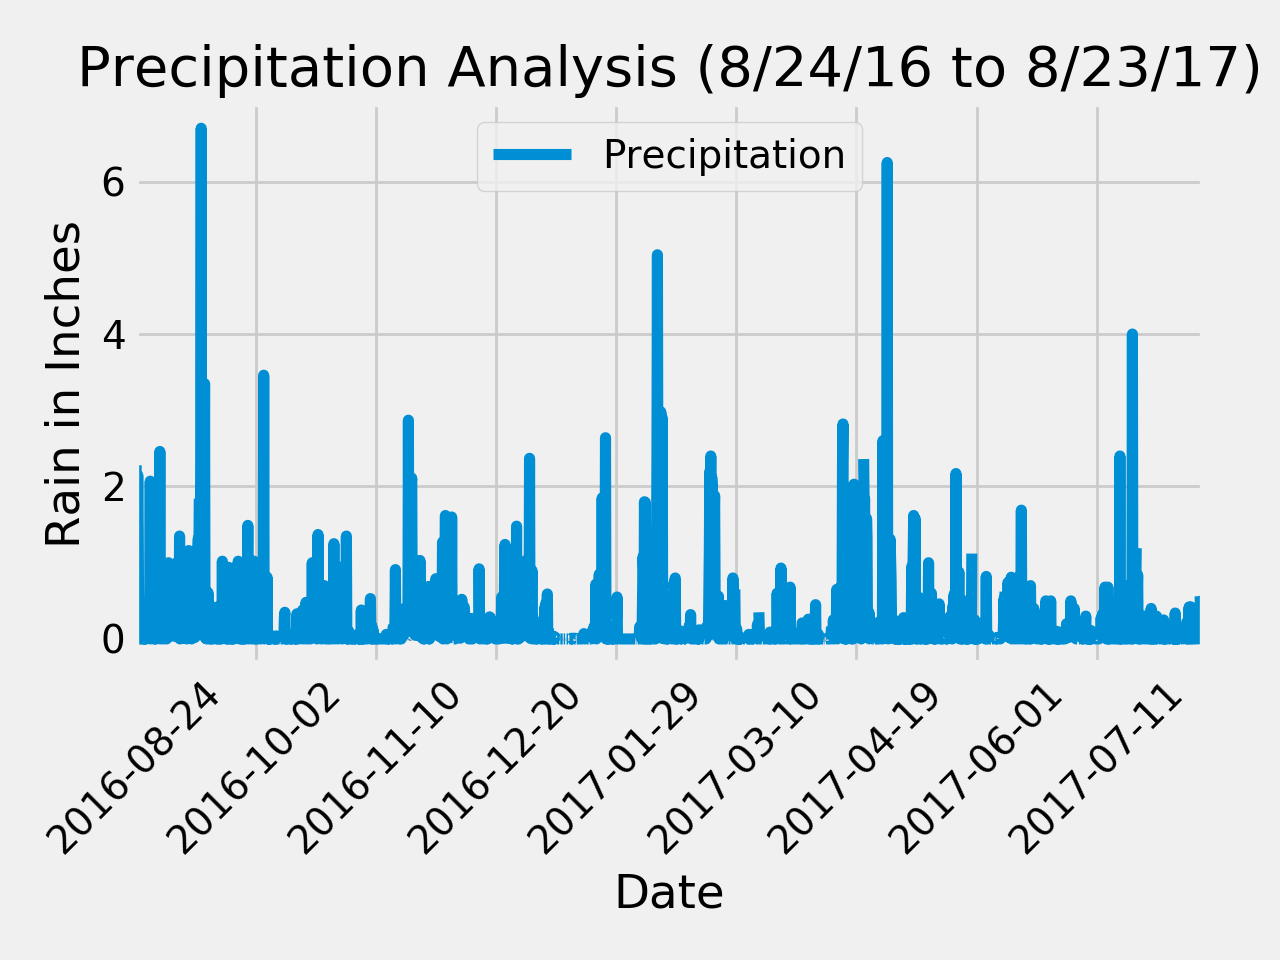

In [83]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)
# Perform a query to retrieve the data and precipitation scores
rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain)
rain_df.head()
# Sort the dataframe by date
rain_df.set_index('date').head()
# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [84]:
 # Use Pandas to calculate the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [85]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print(f"{locations} stations are available.")

9 stations are available.


In [98]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
actives = session.query(Measurements.station, func.count(Measurements.tobs)).group_by(Measurements.station).\
               order_by(func.count(Measurements.tobs).desc()).all()

active = actives[0][0]  
actives

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [87]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = session.query(Measurement.station, 
                                    func.count(Measurement.station).\
                                    label('count')).\
                                    group_by(Measurement.station).\
                                    order_by('count DESC').limit(1)[0][0]
print(most_active)

temp = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
session.query(*temp).filter(Measurement.station==most_active).all()

USC00519281


[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


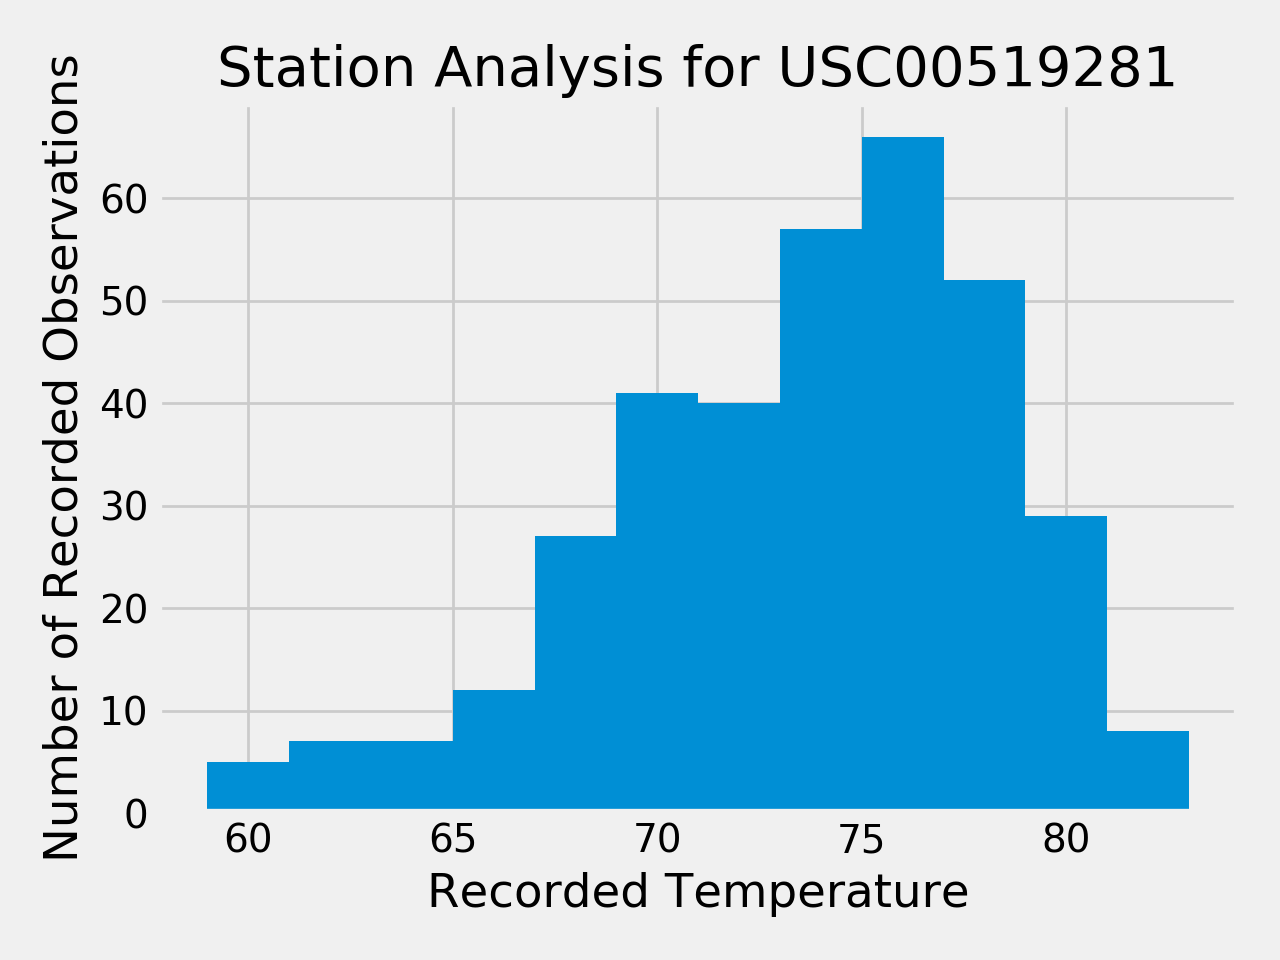

In [104]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurements.station, Measurements.date, Measurements.tobs).\
    filter(Measurements.station == active).\
    filter(Measurements.date > one_year_ago).\
    order_by(Measurements.date).all()

temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis for " + active)
plt.tight_layout()
plt.show()


In [114]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()
range = (temps('2012-02-28', '2012-03-05'))
print(range)

trip_arrive = dt.date(2018, 1, 1)
trip_leave = dt.date(2018, 1, 10)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(62.0, 69.57142857142857, 74.0)]
[(60.0, 68.0327868852459, 77.0)]


<IPython.core.display.Javascript object>


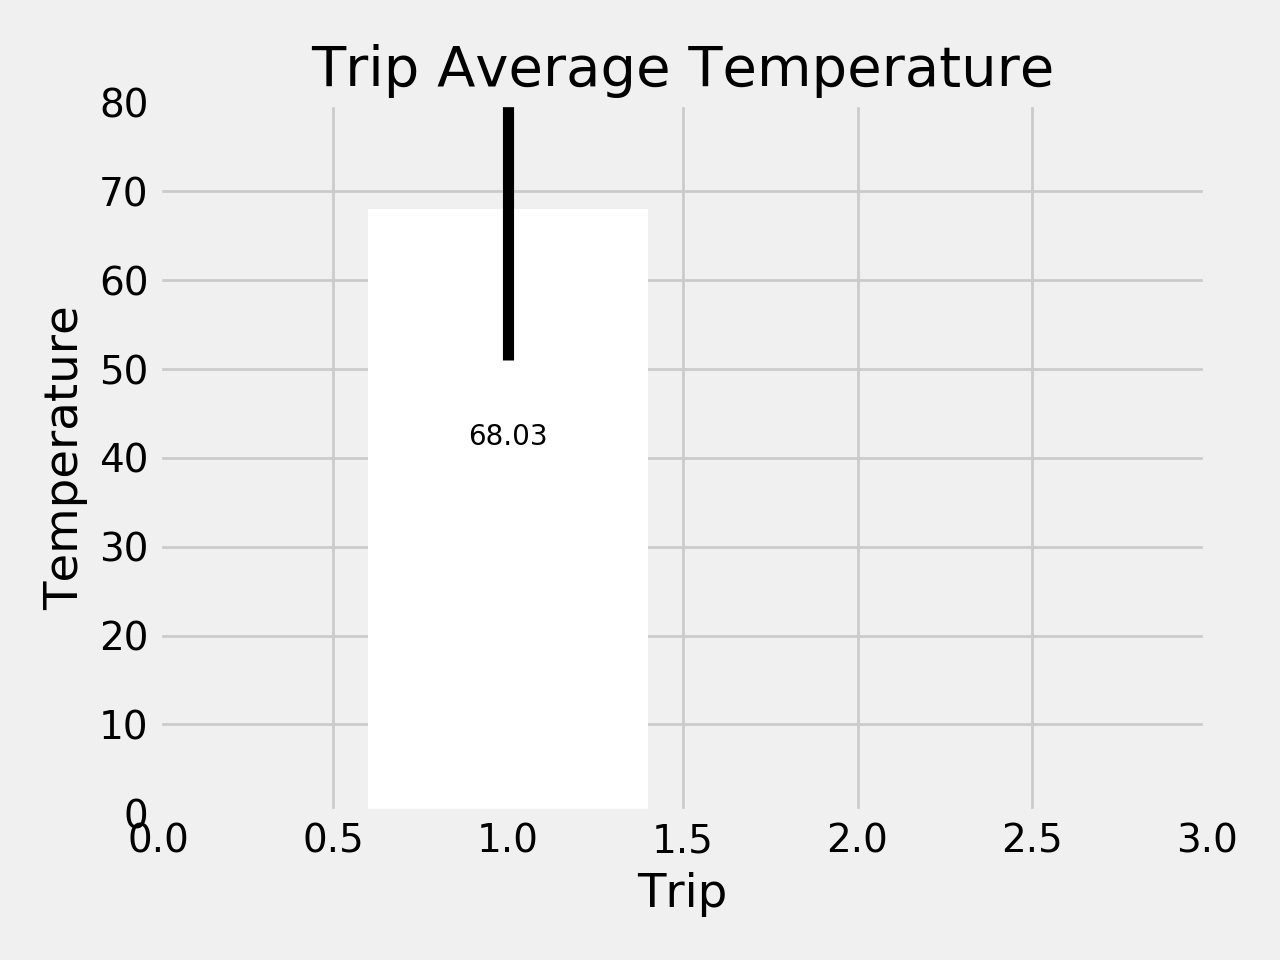

In [122]:
 # Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
p2p = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'w', yerr=p2p)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
ax.set_title("Trip Average Temperature")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)

    # label the bars 
autolabels(bar_chart)        
plt.ylim(0, 80)
plt.xlim(0,3)
fig.tight_layout()
plt.show()